In [ ]:
 # importa libraries necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Autenticação para acesso aos dados
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Download dos dados para esta máquina virtual
downloaded = drive.CreateFile({'id': '1DvEGty2aYwqC3kEeqULqAcaazSSYnWoC'})
downloaded.GetContentFile('data.csv')

In [ ]:
# Carregando os dados baixados no dataframe 
df = pd.read_csv('data.csv')

In [ ]:
#pegamos os dados somente de do mês 11 de 2021 já que o cliente indicou que esse mês deveria ser o mês que deveriamos começar por
mascara  = df["anomes"] == 202111
df = df[mascara]


In [ ]:
#retirar valores Nan do df
df = df[df['cod_rating'].notna()]

In [ ]:
df.cod_rating.unique()

array([ 2.,  1.,  3.,  4.,  5.,  6.,  8.,  7.,  9., 10., 13., 11., 12.,
       15.])

In [ ]:
# fazemos um label enconding, já que um hot encode quando tentamos tornou o dataframe muito pesado, devido aos múltiplos valores de cod_rating
cod_ratings = {
    "HH": 0,
    "H": 1,
    "G":2,
    "F":3,
    "E":4,
    "D":5,
    "C":6,
    "B":7,
    "A":8,
}

df["cod_rating"] = df["cod_rating"].apply(lambda x : cod_ratings[x])


In [ ]:
#dataframe de clientes do banco no mês 11 de 2021
clientes = df[df["num_produtos"].notna()]

In [ ]:
#lista de valores de trocar valores na por 0
preencher = ["num_atend_atrs","num_atend","qtd_oper","qtd_reclm","qtd_restr","ind_engaj"]
#troca os valores
for column in preencher:
  clientes[column].fillna(0, inplace=True)




In [ ]:
# tiramos as colunas com valores vazios restantes
clientes = clientes[ (clientes.vlr_credito.notna()) & (clientes.vlr_saldo.notna()) &  (clientes.vlr_score	.notna())]

In [ ]:
 #tiramos outras colunas de resposta
clientes.drop(["ind_atrito","ind_novo_cli","vlr_renda"],inplace=True,axis=1)

In [ ]:
#dataframe de resposta e de dados

X = clientes[["vlr_credito","vlr_saldo","num_atend_atrs","vlr_score","num_produtos","num_atend","qtd_oper","qtd_reclm","qtd_restr","cod_rating"]]
y = clientes["ind_engaj"]

In [ ]:
#importamos o modelo e metodo de validação
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

dtc = RandomForestClassifier()
tscv = TimeSeriesSplit()

In [ ]:
#importamos o modelo e metodo de validação
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

dtc = DecisionTreeClassifier()
tscv = TimeSeriesSplit()

#o outro foi bem melhor




In [ ]:
cv_results = cross_val_score(dtc,X,y,scoring="f1") 
print(cv_results)

[0.7394877  0.74042768 0.73384346 0.73903514 0.73939422]


In [ ]:
def treating_data(df,mes):
  #pegamos os dados do mês
  df = df[df["anomes"] == mes] 

  #retirar valores Nan do df
  df = df[df['cod_rating'].notna()]

  # fazemos um label enconding, já que um hot encode quando tentamos tornou o dataframe muito pesado, devido aos múltiplos valores de cod_rating
  cod_ratings = {
    "HH": 0,
    "H": 1,
    "G":2,
    "F":3,
    "E":4,
    "D":5,
    "C":6,
    "B":7,
    "A":8,
  }
  try:
    df["cod_rating"] = df["cod_rating"].apply(lambda x : cod_ratings[x])
  except:
    pass 

  #dataframe de clientes do banco no mês selecionado
  clientes = df[df["num_produtos"].notna()]

  #lista de valores de trocar valores na por 0
  preencher = ["num_atend_atrs","num_atend","qtd_oper","qtd_reclm","qtd_restr","ind_engaj"]
  #troca os valores
  for column in preencher:
    clientes[column].fillna(0, inplace=True)

  # tiramos as colunas com valores vazios restantes
  clientes = clientes[ (clientes.vlr_credito.notna()) & (clientes.vlr_saldo.notna()) &  (clientes.vlr_score	.notna())]

  #tiramos outras colunas de resposta
  clientes.drop(["ind_atrito","ind_novo_cli","vlr_renda"],inplace=True,axis=1)    

  #dataframe de resposta e de dados

  X = clientes[["vlr_credito","vlr_saldo","num_atend_atrs","vlr_score","num_produtos","num_atend","qtd_oper","qtd_reclm","qtd_restr","cod_rating"]]
  y = clientes["ind_engaj"]
  return X,y


In [ ]:
X,y = treating_data(df,202111)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [ ]:
#importamos o modelo e metodo de validação
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import plot_confusion_matrix

dtc = RandomForestClassifier()
dtc.fit(X_train,y_train)

RandomForestClassifier()

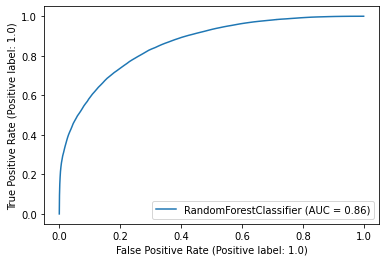

In [ ]:
from sklearn.metrics import confusion_matrix,recall_score,precision_score,plot_roc_curve
y_pred = dtc.predict(X_test)
recall = recall_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)


plot_roc_curve(dtc, X_test, y_test) 

In [ ]:
precision  

0.7884472152492346

In [ ]:
recall

0.7948496899246363

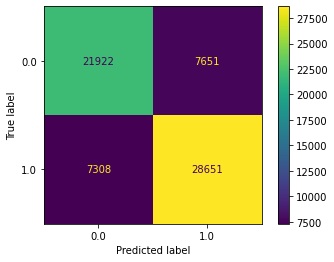

In [ ]:
plot_confusion_matrix(dtc,X_test,y_test)